# Model Calibration

In [1]:
import sys
sys.path.append("../..")
import household_contact_tracing.BranchingProcessSimulation as hct
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss
import seaborn as sns
import pandas as pd
import pickle
from patsy import dmatrices
import statsmodels as sm
import statsmodels.api as sma
sns.set()

In [2]:
def solve_for_x(y, res):
    """
    Used when getting parameters from a linear equation
    """
    c = res.params[0]
    m = res.params[1]
    
    return (y - c) / m

There are a large number of parameters that can be calibrated - we primarily are calibrating to the growth rate, however we have the ability to calibrate to a household secondary attack rate and corresponding growth rate.


Importantly this is the notebook that creates the calibration dictionary.

## Distribution of secondary infections

Simulates the distribution of secondary infections. This is done by Monte Carlo simulating the epidemic for X initial starting households, with X being equal to the starting_infections parameter.

In [3]:
model_calibrator = hct.model_calibration(haz_rate_scale = 0.15,
                                         contact_tracing_success_prob = 0,
                                         household_haz_rate_scale = 0.72219,
                                         overdispersion = 0.36,
                                         infection_reporting_prob = 0.2,
                                         contact_trace_delay_par = 3,
                                         contact_trace = False,
                                         reduce_contacts_by = 0,
                                         starting_infections = 1000)

out = model_calibrator.generate_secondary_infection_distribution()

Text(0.5, 0, 'Secondary Infections')

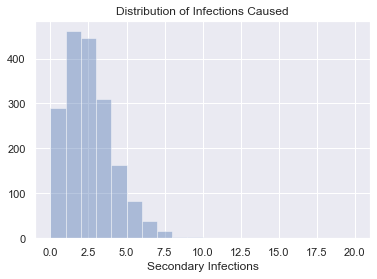

In [4]:
sns.distplot(out, bins = range(21), kde = False)
plt.title("Distribution of Infections Caused")
plt.xlabel("Secondary Infections")

## Growth Rates

We prefer to tune our model to a given growth rate, without contact tracing. The growth rate depends upon a (hazard_rate_cale, infection_reporting_prob) pair and we use the simulation script "Simulate_growth_rates.py" to perform the growth rate simulations and return a data frame of the outputs. We analyse this data frame here.

In [40]:
data = pd.read_excel("../../Data/Calibration/growth_rates.xlsx", index_col = 0)
days_simulated = 20

In [41]:
data

,haz_rate_scale,infection_reporting_prob,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,0.20,0.1,1000,1002,1059,1258,1613,2192,2896,3751,...,7607,9519,11836,14763,18266,22675,27964,34483,42554,52443
1,0.20,0.2,1000,1005,1064,1260,1622,2183,2898,3754,...,7383,9253,11363,14081,17302,21220,25989,31889,39083,47896
2,0.20,0.3,1000,1003,1071,1266,1632,2234,2937,3729,...,7114,8760,10800,13182,16208,19718,23974,29161,35554,43132
3,0.20,0.4,1000,1004,1064,1275,1642,2164,2844,3603,...,6844,8444,10394,12691,15467,18814,22843,27690,33557,40649
4,0.20,0.5,1000,1003,1060,1244,1617,2181,2861,3604,...,6739,8272,10016,12101,14684,17654,21239,25604,30715,36887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.25,0.1,1000,1007,1097,1352,1827,2573,3500,4686,...,10442,13573,17531,22658,29353,37794,48698,62797,80871,104005
246,0.25,0.2,1000,1002,1059,1293,1728,2373,3234,4259,...,9470,12275,15766,20200,26063,33489,43025,54938,70294,89902
247,0.25,0.3,1000,1006,1073,1305,1748,2448,3403,4538,...,9682,12478,16079,20640,26412,33636,42867,54455,69370,88277
248,0.25,0.4,1000,1001,1066,1308,1760,2473,3340,4513,...,9559,12262,15710,19998,25382,32168,40735,51557,65368,82493


## Estimation of Growth Rates:

We fit a linear model to the epidemics and estimate the growth rate of the epidemic.

In [42]:
infection_counts = [str(i) for i in range(days_simulated)]
number_rows = data.shape[0]

In [43]:
data_subset = data[infection_counts]

In [44]:
growth_rates = []

for _ in range(data_subset.shape[0]):
    
    # Which row are we estiamting growth rate for
    print(f"current fit; {_}", end = "\r")
    
    # Difference the counts to get the incidence, take the log to get to the growth rate
    log_diff = data_subset.iloc[_].diff(1).apply(lambda x: np.log(x))

    # temporary dataframe to pass to the linear model
    data_set_up = {
        "log_case_incidence": log_diff[10:days_simulated],
        "time": list(range(10, days_simulated))
    }
    dataframe = pd.DataFrame(data_set_up)

    # Set up the regression
    y, X = dmatrices('log_case_incidence ~ time', 
                     data = dataframe)
    model = sma.RLM(y, X)
    res = model.fit()
    growth_rates.append(res.params[1])

    # Unable to handle missing data, where the epidemic has died out for example
    if res.params[1] == -float("inf"):
        print(f"missing data in line {_}")

In [45]:
growth_rate_data =pd.DataFrame({
    "growth_rate": growth_rates,
    "infection_reporting_prob": data["infection_reporting_prob"],
    "hazard_rate_scale": data["haz_rate_scale"]
})

In [46]:
y, X = dmatrices('growth_rate ~ hazard_rate_scale + infection_reporting_prob', 
                 data = growth_rate_data)
model_1 = sma.OLS(y, X)
res = model_1.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            growth_rate   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 1.172e+04
Date:                Mon, 25 May 2020   Prob (F-statistic):          1.83e-245
Time:                        10:41:13   Log-Likelihood:                 1240.6
No. Observations:                 250   AIC:                            -2475.
Df Residuals:                     247   BIC:                            -2465.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

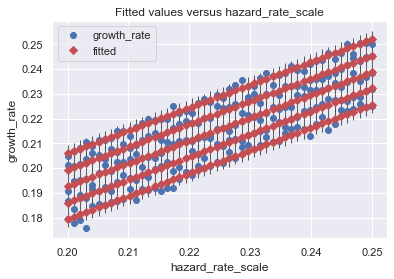

In [47]:
fig = sm.graphics.regressionplots.plot_fit(res, 1)

In [48]:
def solve_for_hazard_rate(results, infection_report_prob, growth_rate):
    """
    Sovles for the required hazard rate from the regression data.
    """
    intercept = res.params[0]
    beta_0 = res.params[1]
    beta_1 = res.params[2]
    hazard_rate_scale = (growth_rate - intercept - beta_1 * infection_report_prob) / beta_0
    return hazard_rate_scale

In [49]:
hazard_rate_getter = lambda infection_report_prob: solve_for_hazard_rate(res, infection_report_prob = infection_report_prob, growth_rate = 0.22)

In [50]:
infection_detect_probs = [0.1, 0.2, 0.3, 0.4, 0.5]
hazard_rates = map(hazard_rate_getter, infection_detect_probs)
hazard_rate_detection_prob_pairs = dict(zip(infection_detect_probs, hazard_rates))

In [51]:
hazard_rate_detection_prob_pairs

{0.1: 0.21523276281929152,
 0.2: 0.22242098020187553,
 0.3: 0.22960919758445958,
 0.4: 0.23679741496704362,
 0.5: 0.24398563234962767}

In [52]:
with open('../../Data/Calibration/hazard_rate_detection_prob_pairs.pickle', 'wb') as handle:
    pickle.dump(hazard_rate_detection_prob_pairs, handle, protocol=pickle.HIGHEST_PROTOCOL)

To load the data use the following:

In [53]:
with open('../../Data/Calibration/hazard_rate_detection_prob_pairs.pickle', 'rb') as handle:
    pairs_dict = pickle.load(handle)


## Calibrating the household secondary attack rate

The following code estimates the household secondary attack rate for a given hazard rate scale by simulating the within household epidemics. The number of simulations performed is equal to the starting_infections value.

In [36]:
model_calibrator = hct.model_calibration(haz_rate_scale = 0,
                                         household_haz_rate_scale = 0.77729,
                                         contact_tracing_success_prob = 2/3,
                                         overdispersion = 0.36,
                                         infection_reporting_prob = 0.2,
                                         contact_trace_delay_par = 3,
                                         contact_trace = False,
                                         reduce_contacts_by = 0,
                                         starting_infections = 2000)

In [37]:
%%time
model_calibrator.estimate_secondary_attack_rate()

Wall time: 23.9 s


0.2724783204016431

To estimate the household secondary attack rate, model calibrator simulates the local epidemics, which is very cheap to do

In [38]:
x = np.linspace(0, 14) 
y = list(map(hct.weibull_pdf, x))

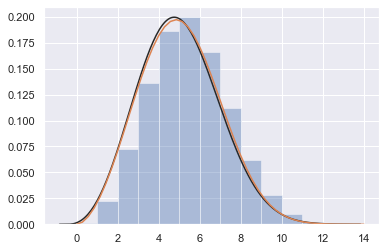

In [39]:
serial_intervals = [node.serial_interval for node in model_calibrator.nodes.all_nodes() if node.generation == 1]
sns.distplot(serial_intervals, bins = range(14), kde = False, fit = ss.exponweib)
plt.plot(x, y)


In [40]:
%%time
secondary_attack_rates = []
for x in np.linspace(0.7, 0.9):
    print(x, end = "\r")
    model_calibrator = hct.model_calibration(haz_rate_scale = 0,
                                            household_haz_rate_scale=x,
                                            contact_tracing_success_prob = 2/3,
                                            overdispersion = 0.36,
                                            infection_reporting_prob = 0.2,
                                            contact_trace_delay_par = 3,
                                            contact_trace = False,
                                            reduce_contacts_by = 0,
                                            starting_infections = 1000)
    secondary_attack_rates.append(model_calibrator.estimate_secondary_attack_rate())
    
data = pd.DataFrame({"household_hazard_rate_scale": np.linspace(0.7, 0.9),
                     "secondary_attack_rate": secondary_attack_rates})

SyntaxError: invalid syntax (<unknown>, line 5)

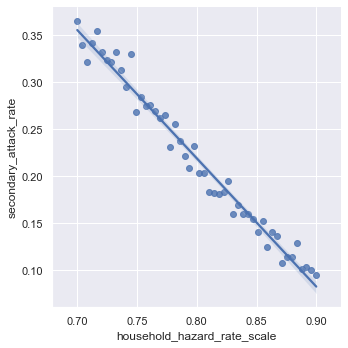

In [93]:
sns.lmplot("household_hazard_rate_scale", "secondary_attack_rate", data = data)

In [94]:
y, X = dmatrices('secondary_attack_rate ~ household_hazard_rate_scale', 
                 data = data)
model_1 = sma.OLS(y, X)
res = model_1.fit()
print(res.summary())

                              OLS Regression Results                             
Dep. Variable:     secondary_attack_rate   R-squared:                       0.976
Model:                               OLS   Adj. R-squared:                  0.975
Method:                    Least Squares   F-statistic:                     1935.
Date:                   Fri, 22 May 2020   Prob (F-statistic):           1.91e-40
Time:                           15:09:27   Log-Likelihood:                 147.49
No. Observations:                     50   AIC:                            -291.0
Df Residuals:                         48   BIC:                            -287.2
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

In [95]:
solve_for_x(0.25, res)

0.7772925726183819

A secondary household attack rate of 35% requires the hazard rate scaling to be around 0.722

### We now have the hazard rate that leads to correctly assumed within household dynamics

In practice we use the script "tune_R0.py" to estimate the $R_0$ value for a range of different inputs, however we demonstrate this below.

In [22]:
household_hazard_rate = solve_for_x(0.35, res)

In [23]:
model_calibrator = hct.model_calibration(haz_rate_scale = 0.81,
                                         household_haz_rate_scale = household_hazard_rate,
                                         contact_tracing_success_prob = 0,
                                         overdispersion = 0.36,
                                         infection_reporting_prob = 0.2,
                                         contact_trace_delay_par = 3,
                                         contact_trace = False,
                                         reduce_contacts_by = 0)

In [ ]:
model_calibration.calculate_R0()

In [80]:
x_vals = np.linspace(0.79, 0.81, 5)
repetitions = 1
hazard_rate_scale = []
R0_estimate = []
for x in x_vals:
    model_calibration = model.model_calibration(haz_rate_scale = x,
                                                household_haz_rate_scale = household_hazard_rate,
                                                contact_tracing_success_prob = 2/3,
                                                contact_trace_delay_par = 1/3,
                                                overdispersion = 0.36,
                                                infection_reporting_prob = 0.7,
                                                contact_trace = True,
                                                reduce_contacts_by = 0)
    for repeat in range(repetitions):
        print(f"x values : {x}   repeat: {repeat}", end = "\r")
        hazard_rate_scale.append(x)
        R0_estimate.append(model_calibration.calculate_R0())

In [30]:
data = pd.read_excel("../../Data/calibration_R0_vals.xlsx")

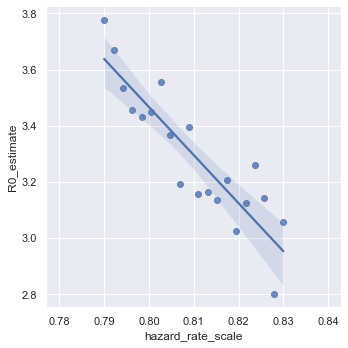

In [31]:
plot = sns.lmplot("hazard_rate_scale", "HH Secondary Attack Rate", data)

In [66]:
y, X = dmatrices('R0_estimate ~ hazard_rate_scale', 
                 data = data)
model_1 = sma.OLS(y, X)
res = model_1.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            R0_estimate   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     69.86
Date:                Sun, 03 May 2020   Prob (F-statistic):           1.31e-07
Time:                        00:35:51   Log-Likelihood:                 16.596
No. Observations:                  20   AIC:                            -29.19
Df Residuals:                      18   BIC:                            -27.20
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            17.1675      1.66

In [67]:
solve_for_x(3.0, res)

0.827243449006354

In [68]:
solve_for_x(2.8, res)

0.8389215257885617

In [69]:
solve_for_x(2.6, res)

0.8505996025707694

## Proving the probabilities give rise to the correct generation times

We simulate a generation time where a contact is guaranteed to happen each day. If an infection does occur, we record the time at which it does occur.

We can change the $\texttt{survive_forever}$ parameter, while maintaining the correct generation times.

In [2]:
x = np.linspace(0, 14) 
y = list(map(hct.weibull_pdf, x))

The hazard rate version

In [8]:
repeats = 10000
times_of_infection_1 = []

for _ in range(repeats):
    is_infected=False
    day = 1

    while is_infected is False and day < 35:

        if np.random.binomial(1, hct.current_prob_infection(day, survive_forever=0.2)) == 1:
            times_of_infection_1.append(day)
            is_infected = True

        day += 1
    

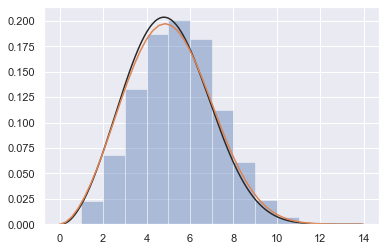

In [9]:
plot = sns.distplot(times_of_infection_1, bins = range(14), fit = ss.weibull_min, kde = False)
plt.plot(x,y)

In [10]:
times_of_infection_1 = np.array(times_of_infection_1)
times_of_infection_1.mean()

4.984066131544267

In [11]:
times_of_infection_1.var()

3.519453791241811

These align with the require mean and standard deviation.

## The scenario where contacts are not always guaranteed to happen

In this scenario, there is a probabiility of a contact happening each day, which is more realistic for the within household model scenario.

* $\texttt{contact_prob}$ - the probability of a contact occuring each day
* $\texttt{survive_forever}$ - controls the overal infectiousness

In [78]:
survive_forever = 0.8
contact_prob = 0.8
day_0_infection_prob = hct.current_prob_infection(0, survive_forever)/contact_prob
infection_probs = np.array(day_0_infection_prob)

for day in range(1, 40):
    survival_function = (1 - infection_probs*contact_prob).prod()
    hazard = hct.current_prob_infection(day, survive_forever=0.8)
    current_prob_infection = hazard * survival_function / contact_prob
    infection_probs = np.append(infection_probs, current_prob_infection)

In [82]:
repeats = 100000
times_of_infection_2 = []
contact_prob = 0.8
for _ in range(repeats):
    is_infected=False
    day = 0

    while is_infected is False and day < 35:

        # Does a contact occur today?
        if np.random.binomial(1, contact_prob) == 1:

            # Is the contact infectious?
            if np.random.binomial(1, infection_probs[day]) == 1:
                times_of_infection_2.append(day)
                is_infected=True

        day += 1

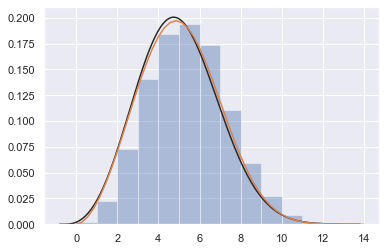

In [83]:
sns.distplot(times_of_infection_2, bins = range(14), fit = ss.exponweib, kde = False)
plt.plot(x, y)

In [84]:
times_of_infection_2 = np.array(times_of_infection_2)
times_of_infection_2.mean()

4.966855857785393

In [85]:
times_of_infection_2.var()

3.7520070558989698